In [1]:
%run ../config/init.py
HTML(hide_code_str())

# Cloud transcriptome annotation
 
__Dataset Name__: PRJNA320545  
__Author__: Roberto Vera Alvarez  
__Email__: veraalva@ncbi.nlm.nih.gov

__Created Date__: 03/24/2020  

### Introduction

The annotation of mRNA transcripts with functional and biological processes is an important step in developing an understanding of the biological complexity of an organism. Annotation is a complex process that requires the integration of multiple biological databases with several software tools.
 
A review of published manuscripts since 2012$^{1-9}$ reveals that many pipelines have a common core component which is the NCBI BLAST sequence comparison tool$^{10}$. BLAST is used to align an assembled transcriptome against annotated databases of nucleotides or proteins. After an assembly, these alignments are the first step to identifying close and/or distant homologous genes, proteins, and functional domains that could be cross-referenced with other public databases, such as Gene Ontology$^{11}$, to generate new annotations on an unkown set of sequeneces.
 
Our study is based on a workflow for [transcriptome annotation](https://github.com/ncbi/cwl-ngs-workflows-cbb/blob/master/workflows/Annotation/transcriptome_annotation.cwl). 

<img src="../doc/transcriptome_annotation.cwl.png" width="600" height="400"/>

This workflow is comprised of five steps that include the key steps required for the transcriptome annotation. First, TransDecoder$^{12}$ is used to generate all open reading frames (ORFs) from the transcripts. Then, BLASTP and RPS-BLAST are used to generate a list of homologous proteins and conserved domains. BLASTP uses the BLAST non-redundant database (nr), and RPS-BLAST uses the NCBI Conserved Domain Database (CDD)$^{13}$. In parallel, BLASTN and RPST-BLASTN are executed, using the BLAST nucleotide database (nt) and the NCBI CDD database, respectively. These steps generate a list of homologous genes and conserved domains. The workflow uses as input a FASTA file (query), with multiple transcripts to process. We also analyzed variations in the query size (i.e. the number of transcripts (sequences) in the file).

We used the transcriptome assembled from a public BioProject (ID [PRJNA320545](https://www.ncbi.nlm.nih.gov/bioproject/PRJNA320545)) from the organism, Opuntia streptacantha, the prickly pear. The transcriptome includes 474,563 transcripts. From this pool of transcripts, three types of query files (FASTA files) were randomly generated, with 2,000, 6,000, and 10,000 transcripts in each. For each query size, 20 different files were generated and processed independently.

### Cloud platforms

We tested our pipeline on two cloud providers, the Google Cloud Platorm (GCP) and on the Amazon Web Servises (AWS) using similar machine types. First (labbeled N1), second (labbeled N2) generation machines from GCP and second generation (M5D and M5DN) instances from AWS were tested with 16, 32 and 64 CPUs.

| Provider | Instance Size | vCPU | Memory (GiB) | Instance Storage (GiB) | Network Bandwidth (Gbps) |  $/Hour |
|---------|---------|----------|----------|-------------|---------------|-----------|
| AWS | m5d.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 10 | 0.904 |
| AWS | m5d.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 10 | 1.808 |
| AWS | m5d.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 20 | 3.616 |
| AWS | m5dn.4xlarge | 16 | 64 | 2 x 300 NVMe SSD | Up to 25 | 1.088 |
| AWS | m5dn.8xlarge | 32 | 128 | 2 x 600 NVMe SSD | 25 | 2.176 |
| AWS | m5dn.16xlarge | 64 | 256 | 4 x 600 NVMe SSD | 75 | 4.352 |
| GCP | n1-standard-16 | 16 | 60 | 24 x 375 NVMe SSD | 32 | 0.861 |
| GCP | n1-standard-32 | 32 | 120 | 24 x 375 NVMe SSD | 32 | 1.393 |
| GCP | n1-standard-64 | 64 | 240 | 24 x 375 NVMe SSD | 32 | 2.475 |
| GCP | n2-standard-16 | 16 | 64 | 24 x 375 NVMe SSD | 32 | 0.951 |
| GCP | n2-standard-32 | 32 | 128 | 24 x 375 NVMe SSD | 32 | 1.572 |
| GCP | n2-standard-64 | 64 | 256 | 24 x 375 NVMe SSD | 32 | 2.816 |

 
Times and cost were analyzed and are shown in the following figures. For each query size, four plots are shown. First, in the top of the figure, total running time and cost per configuration for the 20 sample files processed is shown. Each sample file can be identified with a color. They keep their relative position on each configuration demonstrating that there is not outliers due to specific problems with the instances. Second, in the bottom of the figure three plots are shown. In these cases, the cost on each configuration is expressed in percent of the total cost. The plot in the left shows the time for instance creation, setup and release. The plot in the middle show the time to transfer the BLAST databases, currently 342 GB (including nt, nr and CDD) to the instance local disk. Finally, the plot in the right shows the time to execute the CWL workflow analysis.


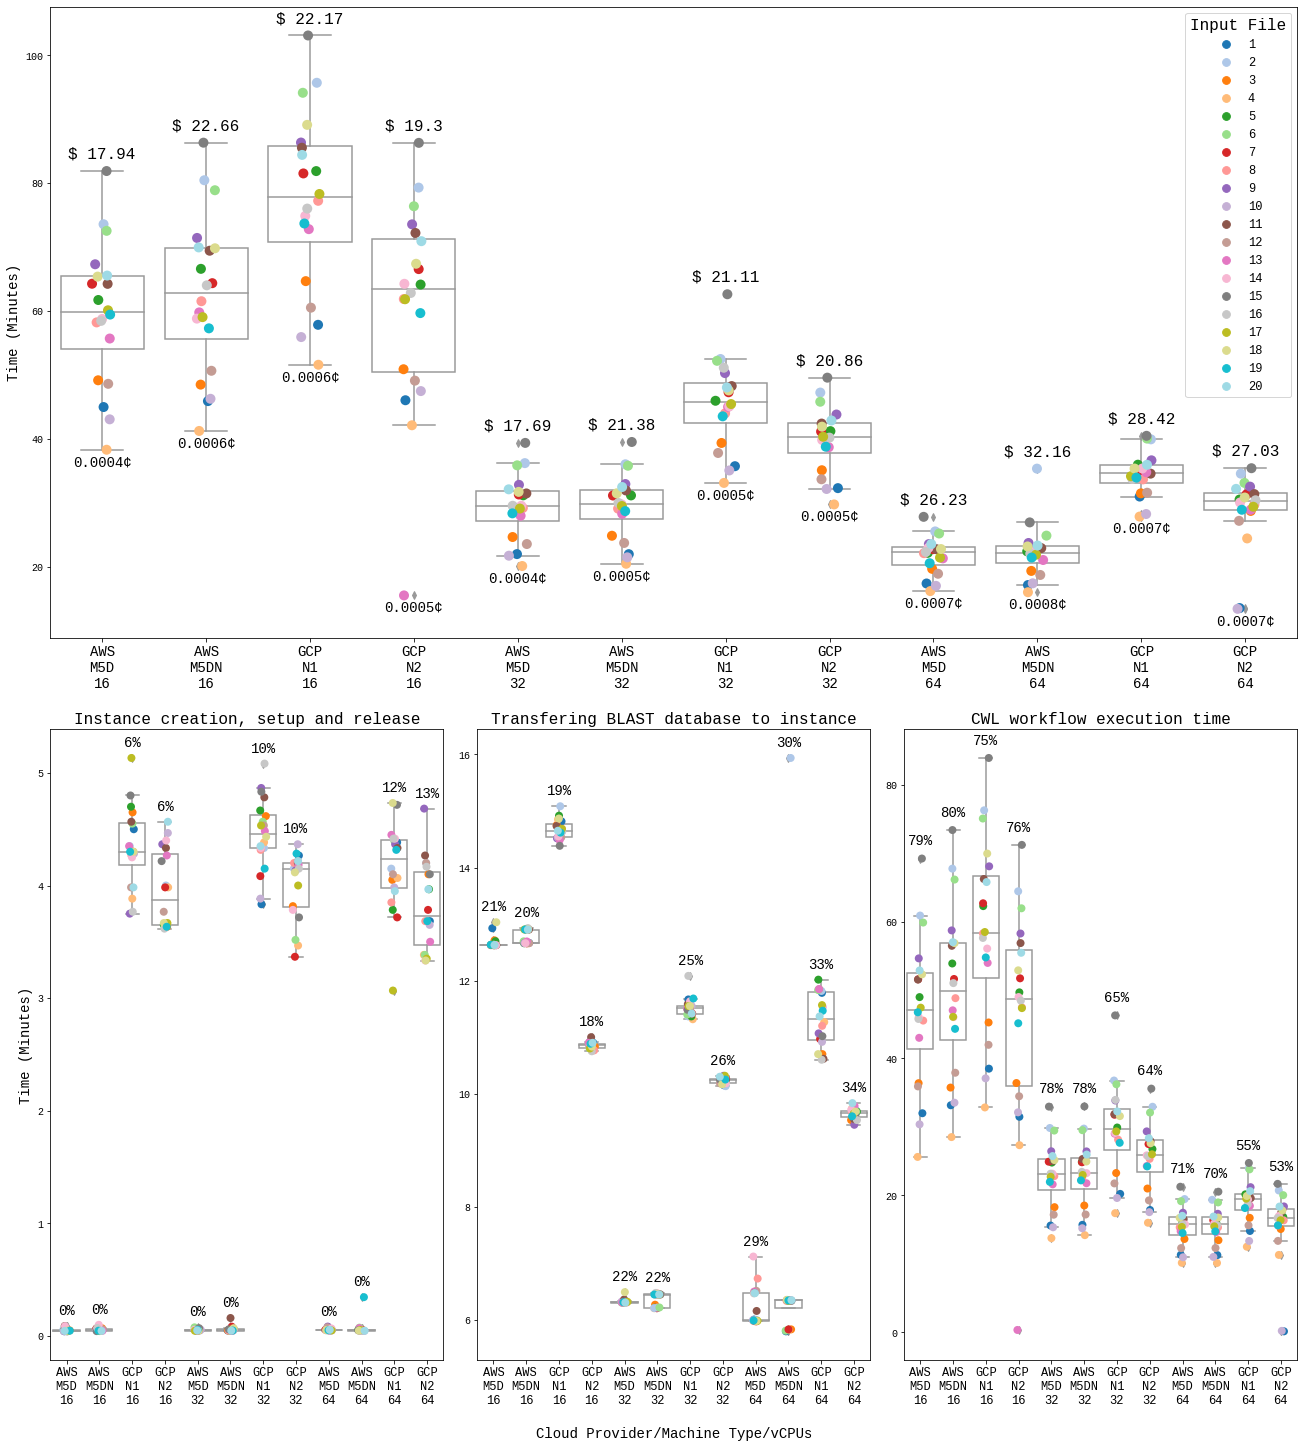

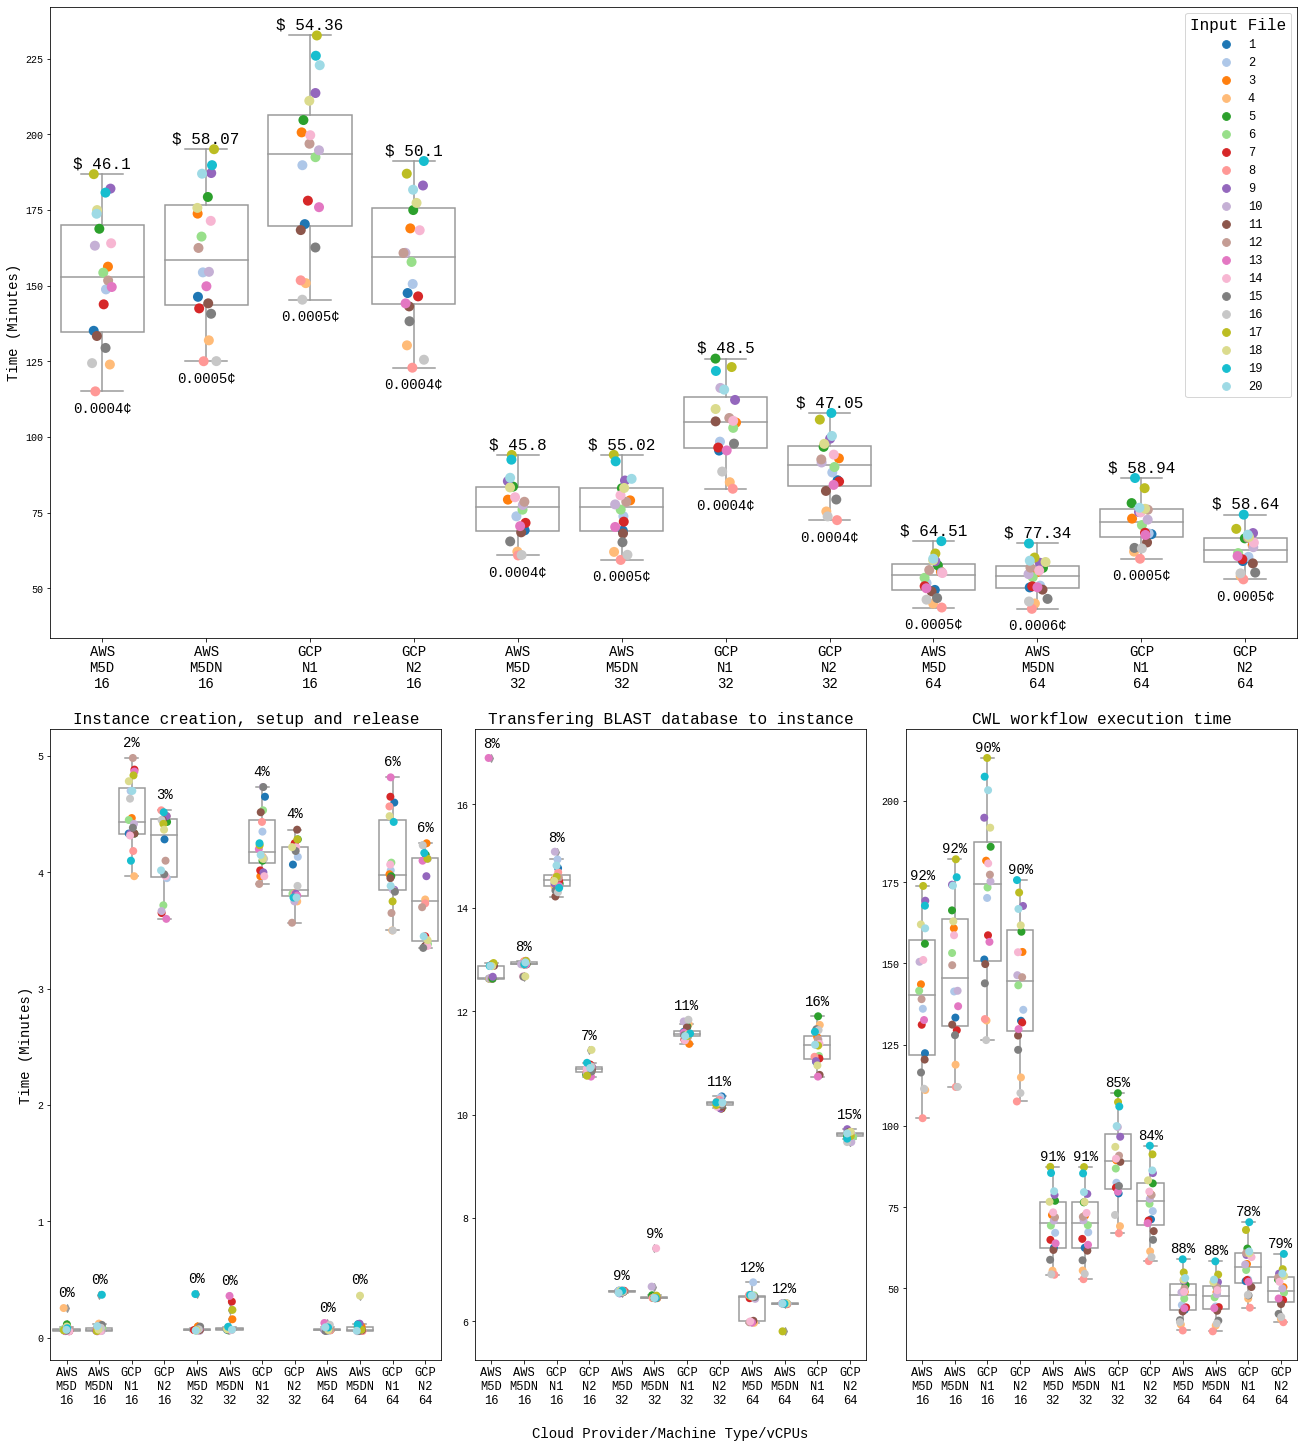

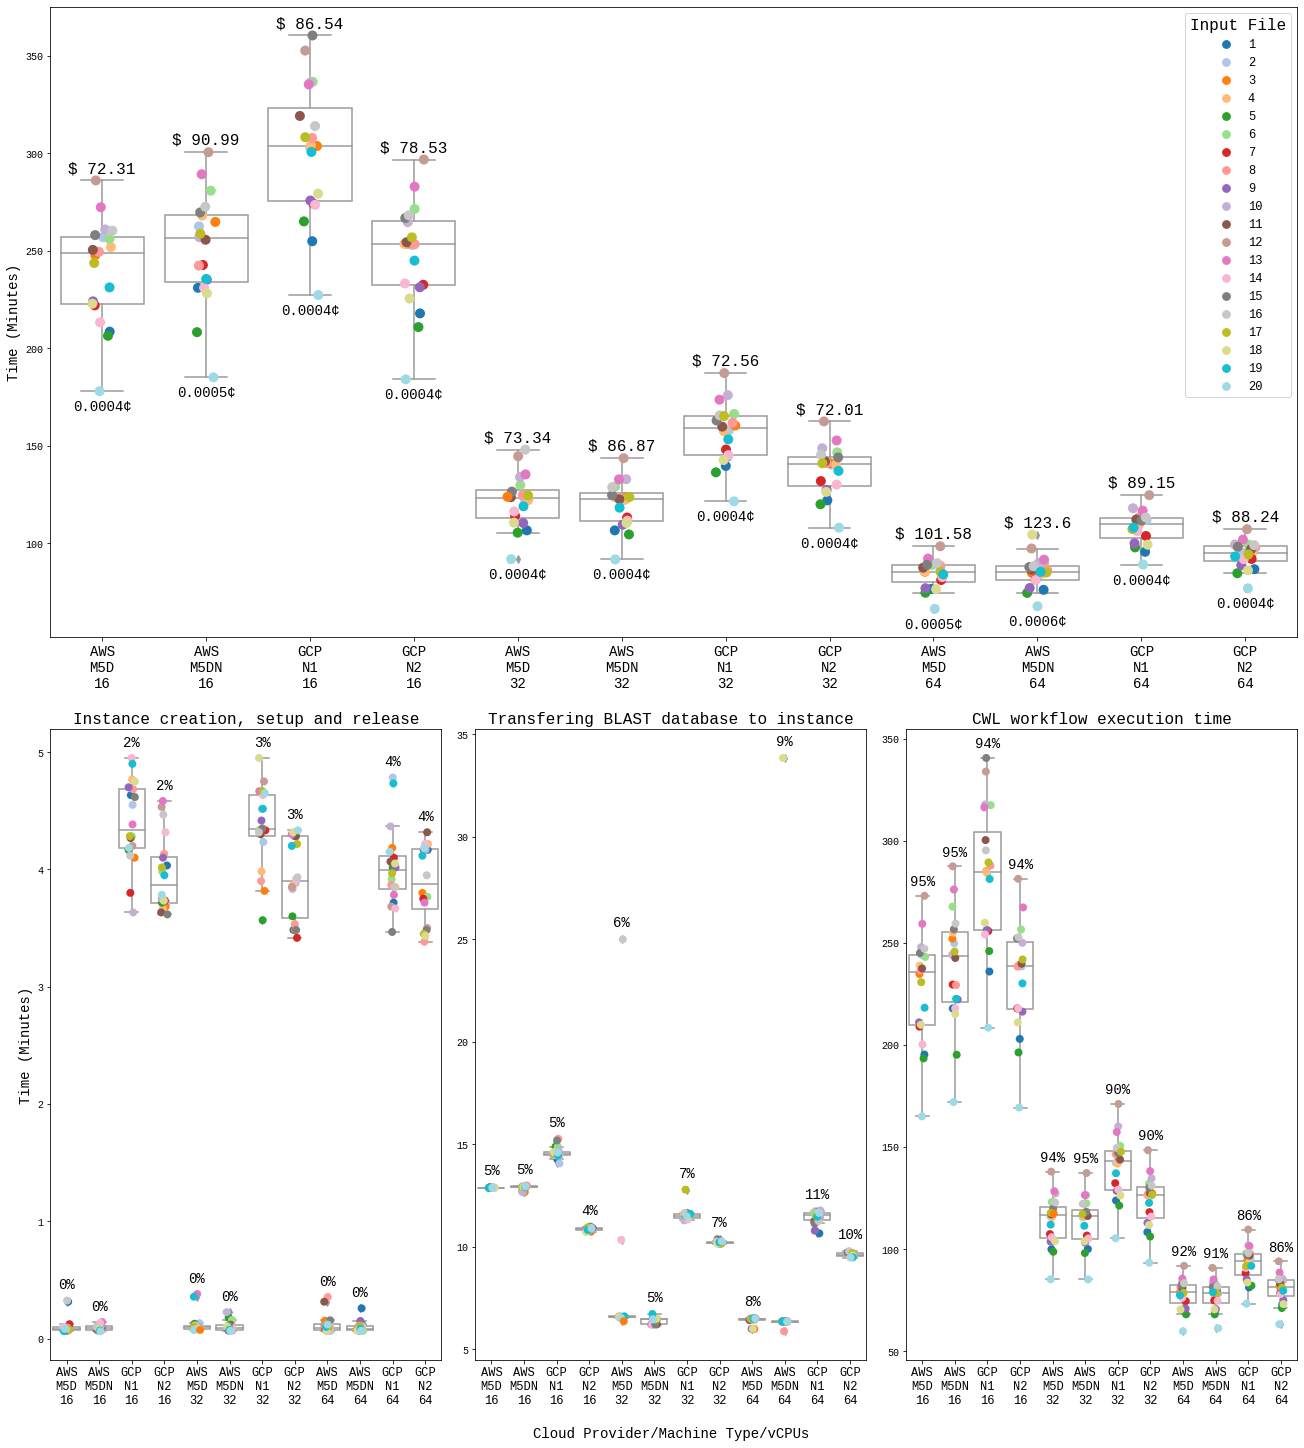

In [2]:
QUERY_SIZES = [2000, 6000, 10000]

# Prices from 03/04/2020
MACHINE_TYPE = {
    'n1':[{ 'name':'GCP\nN1\n16', 'CPUs': 16, 'price': 0.861 }, 
          { 'name':'GCP\nN1\n32', 'CPUs': 32, 'price': 1.393 },
          { 'name':'GCP\nN1\n64', 'CPUs': 64, 'price': 2.475 }], 
    'n2':[{ 'name':'GCP\nN2\n16', 'CPUs': 16, 'price': 0.951 },
          { 'name':'GCP\nN2\n32', 'CPUs': 32, 'price': 1.572 }, 
          { 'name':'GCP\nN2\n64', 'CPUs': 64, 'price': 2.816 }],
    'm5d':[{ 'name':'AWS\nM5D\n16', 'CPUs': 16, 'price': 0.904 }, 
           { 'name':'AWS\nM5D\n32', 'CPUs': 32, 'price': 1.808 },
           { 'name':'AWS\nM5D\n64', 'CPUs': 64, 'price': 3.616 }],
    'm5dn':[{ 'name':'AWS\nM5DN\n16', 'CPUs': 16, 'price': 1.088 }, 
            { 'name':'AWS\nM5DN\n32', 'CPUs': 32, 'price': 2.176 },
            { 'name':'AWS\nM5DN\n64', 'CPUs': 64, 'price': 4.352 }]    
}

result_dir = os.path.join(RESULTS, DATASET)
if not os.path.exists(result_dir):
    os.mkdir(result_dir) 
os.chdir(result_dir)

def aws_get_sample_name(environments):
    for e in environments:
        if e['name'] == 'SAMPLE':
            return e['value']
    return ''

for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    os.chdir(q_dir)
    data = []
    for m in MACHINE_TYPE:
        m_dir = os.path.join(q_dir, m)
        os.chdir(m_dir)
        for t in MACHINE_TYPE[m]:
            c_dir = os.path.join(m_dir, str(t['CPUs']))
            os.chdir(c_dir)
            if m.startswith('n'):
                files = [ f for ds, dr, files in os.walk('./') for f in files if f.endswith('.json.gz') ]
                for f in files:
                    with gzip.GzipFile(f, 'r') as fin:  
                        l = json.loads(fin.read().decode('utf-8'))
                        n = int(l['metadata']['pipeline']['environment']['SAMPLE'].replace(str(q)+ '_', ''))
                        d = parse_gcp_json(l, n)
                        total = d[1]/pandas.Timedelta('1 minute')
                        blast = d[2]/pandas.Timedelta('1 minute')
                        cwl = d[3]/pandas.Timedelta('1 minute')
                        price = (total/60) * t['price']
                        blast_price = (blast/60) * t['price']
                        cwl_price = (cwl/60) * t['price']
                        s = total - (blast + cwl)
                        s_time = (s/60) * t['price']
                        data.append([t['name'], n, total, blast, cwl, price, blast_price, cwl_price, s, s_time])
            elif m.startswith('m'):
                files = [ f for ds, dr, files in os.walk('./') for f in files if f.endswith('_job.json.gz') ]
                for f in files:
                    with gzip.GzipFile(f, 'r') as fin:  
                        l = json.loads(fin.read().decode('utf-8'))
                        n = int(aws_get_sample_name(l['jobs'][0]['container']['environment']).replace(str(q)+ '_', ''))
                        s = l['jobs'][0]['startedAt']
                        e = l['jobs'][0]['stoppedAt']                        
                        total = (e-s)/(1000*60)
                        price = (total/60) * t['price']
                        with gzip.GzipFile(f.replace('_job', '_log'), 'r') as fin:  
                            log = json.loads(fin.read().decode('utf-8'))
                        blast, cwl = aws_log_times(log['events'])
                        blast_price = (blast/60) * t['price']
                        cwl_price = (cwl/60) * t['price']
                        s = total - (blast + cwl)
                        s_time = (s/60) * t['price']
                        data.append([t['name'], n, total, blast, cwl, price, blast_price, cwl_price, s, s_time])
    df = pandas.DataFrame(data, columns=['Instance Type', 'Query', 'Time', 'BlastDB', 'CWL', 'Price', 'BlastDB Price', 'CWL Price', 'Setup', 'Setup Price'])
    new = df['Instance Type'].str.split("\n", n = 2, expand = True)
    df['cloud'] = new[0]
    df['machine'] = new[1]
    df['cpu'] = new[2]
    df = df.sort_values(by=['cpu', 'machine', 'cloud']) 
  
    fig = plt.figure(figsize=(18,20), constrained_layout=True)

    gs = GridSpec(2, 3, figure=fig)

    ax1 = fig.add_subplot(gs[0, :])
    top = []
    low = []
    billed = []
    cost = []
    for p in df['Instance Type'].unique():
        f = p.lower().split('\n')
        top.append(df[df['Instance Type'] == p]['Time'].max())
        low.append(df[df['Instance Type'] == p]['Time'].min())
        billed.append('$ {}'.format(round(df[df['Instance Type'] == p]['Price'].sum(), 2)))
        cost.append('{:.4f}¢'.format(df[df['Instance Type'] == p]['Price'].sum()/(int(q) * 20)))

    box_plot = sns.boxplot(x="Instance Type", y="Time", data=df, color='white', ax=ax1)

    top_tick = 2
    low_tick = 2.5
    if q == 6000:
        low_tick = 6.8
    if q == 10000:
        top_tick = 4
        low_tick = 9.8

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',fontsize=16 ,weight='normal')

    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,low[xtick] - low_tick,cost[xtick], 
                horizontalalignment='center',fontsize=14 ,weight='normal')                                      

    g = sns.stripplot(hue="Query", y="Time", x='Instance Type', data=df, palette='tab20', size=10, ax=ax1)
    ax1.tick_params(axis='x', labelsize=14)
    ax1.set_ylabel("Time (Minutes)", fontsize=14)
    ax1.set_xlabel("")
#     ax1.set_title(locale.format_string("%d", int(q), grouping=True)
#                   + ' transcripts per sample for a total processed of ' 
#                   + locale.format_string("%d", int(q) * 20, grouping=True)
#                   + ' transcripts', fontsize=16)

    g.legend(title='Input File', title_fontsize=16, fontsize=12)

    ax2 = fig.add_subplot(gs[1, 1])
    top = []
    billed = []
    for p in df['Instance Type'].unique():
        f = p.lower().split('\n')
        top.append(df[df['Instance Type'] == p]['BlastDB'].max())
        t = df[df['Instance Type'] == p]['Price'].sum()
        b = df[df['Instance Type'] == p]['BlastDB Price'].sum()
        billed.append('{:.0f}%'.format(round(b * 100/t, 1)))

    box_plot = sns.boxplot(x="Instance Type", y="BlastDB", data=df, color='white', ax=ax2)

    top_tick = 0.2
    if q == 10000:
        top_tick = 0.6
    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',fontsize=14 ,weight='normal')

    g = sns.stripplot(hue="Query", y="BlastDB", x='Instance Type', data=df, palette='tab20', size=8, ax=ax2)
    ax2.tick_params(axis='x', labelsize=12)
    g.legend_.remove()
    ax2.set_ylabel("")
    ax2.set_xlabel("\nCloud Provider/Machine Type/vCPUs", fontsize=14)
    ax2.set_title("Transfering BLAST database to instance", fontsize=16)

    ax3 = fig.add_subplot(gs[1, 2])
    top = []
    billed = []
    for p in df['Instance Type'].unique():
        f = p.lower().split('\n')
        top.append(df[df['Instance Type'] == p]['CWL'].max())
        t = df[df['Instance Type'] == p]['Price'].sum()
        b = df[df['Instance Type'] == p]['CWL Price'].sum()
        billed.append('{:.0f}%'.format(round(b * 100/t, 1)))

    box_plot = sns.boxplot(x="Instance Type", y="CWL", data=df, color='white', ax=ax3)

    top_tick = 2    
    if q == 10000:
        top_tick = 5
    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',fontsize=14 ,weight='normal')

    g = sns.stripplot(hue="Query", x="Instance Type", y="CWL", data=df, palette='tab20', size=8, ax=ax3)
    ax3.tick_params(axis='x', labelsize=12)
    g.legend_.remove()
    ax3.set_ylabel("")
    ax3.set_xlabel("")
    ax3.set_title("CWL workflow execution time", fontsize=16)

    ax4 = fig.add_subplot(gs[1, 0])
    top = []
    billed = []
    for p in df['Instance Type'].unique():
        f = p.lower().split('\n')
        top.append(df[df['Instance Type'] == p]['Setup'].max())
        t = df[df['Instance Type'] == p]['Price'].sum()
        b = df[df['Instance Type'] == p]['Setup Price'].sum()
        billed.append('{:.0f}%'.format(round(b * 100/t, 1)))

    box_plot = sns.boxplot(x="Instance Type", y="Setup", data=df, color='white', ax=ax4)

    top_tick = 0.1
    for xtick in box_plot.get_xticks():
        box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
                horizontalalignment='center',fontsize=14 ,weight='normal')

    g = sns.stripplot(hue="Query", x="Instance Type", y="Setup", data=df, palette='tab20', size=8, ax=ax4)
    ax4.tick_params(axis='x', labelsize=12)
    g.legend_.remove()
    ax4.set_ylabel("Time (Minutes)", fontsize=14)
    ax4.set_xlabel("")
    ax4.set_title("Instance creation, setup and release", fontsize=16)
    
    if q == 10000:
        fig.savefig(os.path.join(DOC,'{}.png'.format(q)), dpi=300)

    plt.show()

The next figure shows total running time for all tested configuration and query sizes. 

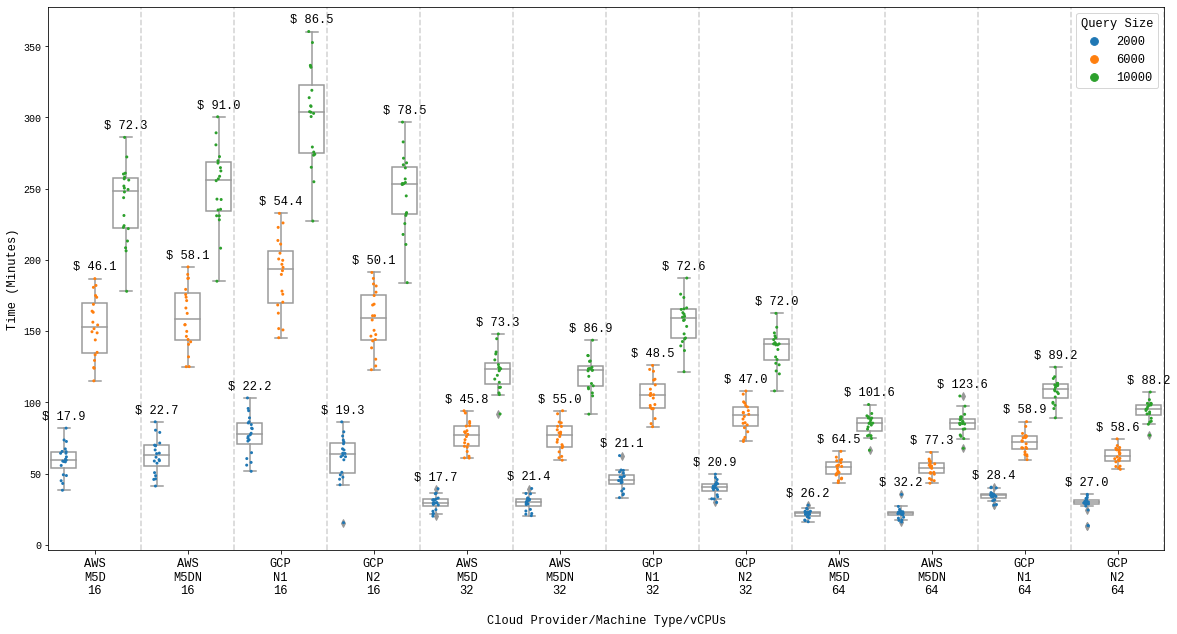

In [3]:
data = []
for q in QUERY_SIZES:
    q_dir = os.path.join(result_dir, str(q))
    os.chdir(q_dir)    
    for m in MACHINE_TYPE:
        m_dir = os.path.join(q_dir, m)
        os.chdir(m_dir)
        for t in MACHINE_TYPE[m]:
            c_dir = os.path.join(m_dir, str(t['CPUs']))
            os.chdir(c_dir)
            if m.startswith('n'):
                files = [ f for ds, dr, files in os.walk('./') for f in files if f.endswith('.json.gz') ]
                for f in files:
                    with gzip.GzipFile(f, 'r') as fin:  
                        l = json.loads(fin.read().decode('utf-8'))
                        n = int(l['metadata']['pipeline']['environment']['SAMPLE'].split('_')[0])
                        d = parse_gcp_json(l, n)
                        total = d[1]/pandas.Timedelta('1 minute')
                        price = (total/60) * t['price']
                        data.append([t['name'] + '-' + str(q), n, total, price])
            elif m.startswith('m'):
                files = [ f for ds, dr, files in os.walk('./') for f in files if f.endswith('_job.json.gz') ]
                for f in files:
                    with gzip.GzipFile(f, 'r') as fin:  
                        l = json.loads(fin.read().decode('utf-8'))
                        n = int(aws_get_sample_name(l['jobs'][0]['container']['environment']).split('_')[0])
                        s = l['jobs'][0]['startedAt']
                        e = l['jobs'][0]['stoppedAt']                        
                        total = (e-s)/(1000*60)
                        price = (total/60) * t['price']
                        data.append([t['name'] + '-' + str(q), n, total, price])
df = pandas.DataFrame(data, columns=['Instance Type', 'Query Size', 'Time', 'Price'])
new = df['Instance Type'].str.split("\n", n = 2, expand = True)
df['cloud'] = new[0]
df['machine'] = new[1]
new = new[2].str.split("-", n = 1, expand = True)
df['cpu'] = new[0]
df = df.sort_values(by=['cpu', 'machine', 'cloud', 'Query Size'])   

fig, axs = plt.subplots(figsize=(20,10), ncols=1)

box_plot = sns.boxplot(x="Instance Type", y="Time", data=df, color='white', ax=axs)  

top = []
low = []
billed = []
cost = []
for p in df['Instance Type'].unique():
    f = p.lower().split('\n')
    top.append(df[df['Instance Type'] == p]['Time'].max())
    low.append(df[df['Instance Type'] == p]['Time'].min())
    billed.append('$ {}'.format(round(df[df['Instance Type'] == p]['Price'].sum(), 1)))
    cost.append('{:.2f}¢'.format(round(df[df['Instance Type'] == p]['Price'].sum()/(int(q) * 20),3)))

top_tick = 6
low_tick = 5

for xtick in box_plot.get_xticks():
    box_plot.text(xtick,top[xtick] + top_tick,billed[xtick], 
            horizontalalignment='center',fontsize=12,weight='normal')                                  

g = sns.stripplot(hue="Query Size", y="Time", x='Instance Type', data=df, size=3, ax=axs)

xticks = axs.xaxis.get_major_ticks()
ticklabels = []
for i in range(0, len(axs.get_xticklabels())) :
    t = axs.get_xticklabels()[i]
    if np.mod(2* i + 1, 3) == 0:
        ticklabels.append(t.get_text().split('-')[0])
        axs.axvline(i + 1.5, linestyle='--', color='lightgray')
    else:
        ticklabels.append(' ')
        xticks[i].set_visible(False)
        
axs.set_xticklabels(ticklabels)
g.legend(title='Query Size', title_fontsize=12, fontsize=12)
axs.set_ylabel("Time (Minutes)", fontsize=12)
axs.set_xlabel("\nCloud Provider/Machine Type/vCPUs", fontsize=12)
axs.tick_params(axis='x', labelsize=12)

fig.savefig(os.path.join(DOC,'all.png'), dpi=300)
plt.show()

### References

1.	Al-Qurainy, F. et al. Comprehensive Stress-Based De Novo Transcriptome Assembly and Annotation of Guar (Cyamopsis tetragonoloba (L.) Taub.): An Important Industrial and Forage Crop. Int J Genomics 2019, 7295859, doi:10.1155/2019/7295859 (2019).
2.	Chabikwa, T. G., Barbier, F. F., Tanurdzic, M. & Beveridge, C. A. De novo transcriptome assembly and annotation for gene discovery in avocado, macadamia and mango. Sci Data 7, 9, doi:10.1038/s41597-019-0350-9 (2020).
3.	Ji, P. et al. Characterization of common carp transcriptome: sequencing, de novo assembly, annotation and comparative genomics. PLoS One 7, e35152, doi:10.1371/journal.pone.0035152 (2012).
4.	Torre, S. et al. RNA-seq analysis of Quercus pubescens Leaves: de novo transcriptome assembly, annotation and functional markers development. PLoS One 9, e112487, doi:10.1371/journal.pone.0112487 (2014).
5.	Carruthers, M. et al. De novo transcriptome assembly, annotation and comparison of four ecological and evolutionary model salmonid fish species. BMC Genomics 19, 32, doi:10.1186/s12864-017-4379-x (2018).
6.	Haas, B. J. et al. De novo transcript sequence reconstruction from RNA-seq using the Trinity platform for reference generation and analysis. Nat Protoc 8, 1494-1512, doi:10.1038/nprot.2013.084 (2013).
7.	Bryant, D. M. et al. A Tissue-Mapped Axolotl De Novo Transcriptome Enables Identification of Limb Regeneration Factors. Cell Rep 18, 762-776, doi:10.1016/j.celrep.2016.12.063 (2017).
8.	Vera Alvarez, R. et al. Workflow and web application for annotating NCBI BioProject transcriptome data. Database (Oxford) 2017, doi:10.1093/database/bax008 (2017).
9.	Gamez, R. M. et al. Banana (Musa acuminata) transcriptome profiling in response to rhizobacteria: Bacillus amyloliquefaciens Bs006 and Pseudomonas fluorescens Ps006. BMC Genomics 20, 378, doi:10.1186/s12864-019-5763-5 (2019).
10.	Altschul, S. F., Gish, W., Miller, W., Myers, E. W. & Lipman, D. J. Basic local alignment search tool. J Mol Biol 215, 403-410, doi:10.1016/S0022-2836(05)80360-2 (1990).
11.	Ashburner, M. et al. Gene ontology: tool for the unification of biology. The Gene Ontology Consortium. Nat Genet 25, 25-29, doi:10.1038/75556 (2000).
12.	Haas, B. & Papanicolaou, A. TransDecoder (Find Coding Regions Within Transcripts), <https://github.com/TransDecoder/TransDecoder/wiki> (2020).
13.	Yang, M., Derbyshire, M. K., Yamashita, R. A. & Marchler-Bauer, A. NCBI's Conserved Domain Database and Tools for Protein Domain Analysis. Curr Protoc Bioinformatics 69, e90, doi:10.1002/cpbi.90 (2020).
  